<a href="https://colab.research.google.com/github/MichalskaMagda/ProgramowanieRownolegleiRozproszone/blob/Zadanie2/zadanie2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cupy as cp
import time
import numpy as np
start = time.time()
N = 1024
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)
A_gpu = cp.array(A_cpu)
B_gpu = cp.array(B_cpu)
start = time.time()
C_gpu = cp.matmul(A_gpu, B_gpu)
cp.cuda.Stream.null.synchronize() # Synchronizacja z GPU
end = time.time()
print(f"Mnożenie macierzy na GPU trwało: {end- start:.5f} sekund.")

CUBLASError: CUBLAS_STATUS_EXECUTION_FAILED

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pycuda



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=ae9df9e3a1fcfd6dadb7c0eb3e063a31caac24d6e434d9f1eae162b261fc5a19
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  float sum = 0.0;
  if(row < N && col < N) {
    for (int k = 0; k < N; k++) {
      sum += A[row * N + k] * B[k * N + col];
    }
    C[row * N + col] = sum;
 }
}

"""


In [ ]:
N = 1024
mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")

C_cpu = np.empty((N,N), np.float32)
A_gpu = cuda.mem_alloc(A_cpu.nbytes)
B_gpu = cuda.mem_alloc(B_cpu.nbytes)
C_gpu = cuda.mem_alloc(C_cpu.nbytes)

cuda.memcpy_htod(A_gpu, A_cpu)
cuda.memcpy_htod(B_gpu, B_cpu)
block_size = (32, 32, 1)
print(f"Warp {block_size}")

grid_size = (int(N/32), int(N/32), 1)
print(f"Grid {grid_size}")

start_time = time.time()
matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)

cuda.Context.synchronize()
cuda.memcpy_dtoh(C_cpu, C_gpu)

end_time = time.time()
print(f"Mnożenie macierzy niskopoziomowo na GPU trwało: {end_time- start_time:.5f} sekund.")

del A_gpu
del B_gpu
del C_gpu

Warp (32, 32, 1)
Grid (32, 32, 1)
Mnożenie macierzy niskopoziomowo na GPU trwało: 0.01224 sekund.


In [ ]:
# pomiary
import numpy as np
import time
Ns = [32, 64, 128, 256, 512 ,1024, 2048, 4096 ,8192]
times = []
for N in Ns:
    print(f"--------------")
    A_cpu = np.random.rand(N, N).astype(np.float32)
    B_cpu = np.random.rand(N, N).astype(np.float32)
    C_cpu = np.empty((N, N), np.float32)

    A_gpu = cuda.mem_alloc(A_cpu.nbytes)
    B_gpu = cuda.mem_alloc(B_cpu.nbytes)
    C_gpu = cuda.mem_alloc(C_cpu.nbytes)

    cuda.memcpy_htod(A_gpu, A_cpu)
    cuda.memcpy_htod(B_gpu, B_cpu)
    block_size = (32, 32, 1)
    grid_size = (int(N / 32), int(N / 32), 1)

    print(f"Warp: {block_size}")
    print(f"Grid size: {grid_size}")

    start_time = time.time()
    matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
    cuda.Context.synchronize()
    end_time = time.time()

    cuda.memcpy_dtoh(C_cpu, C_gpu)
    times.append(end_time - start_time)
    del A_gpu
    del B_gpu
    del C_gpu
    print(f"Czas mnożenia macierzy na GPU: {end_time - start_time:.5f} sekund")




--------------
Warp: (32, 32, 1)
Grid size: (1, 1, 1)
Czas mnożenia macierzy na GPU: 0.00011 sekund
--------------
Warp: (32, 32, 1)
Grid size: (2, 2, 1)
Czas mnożenia macierzy na GPU: 0.00007 sekund
--------------
Warp: (32, 32, 1)
Grid size: (4, 4, 1)
Czas mnożenia macierzy na GPU: 0.00070 sekund
--------------
Warp: (32, 32, 1)
Grid size: (8, 8, 1)
Czas mnożenia macierzy na GPU: 0.00017 sekund
--------------
Warp: (32, 32, 1)
Grid size: (16, 16, 1)
Czas mnożenia macierzy na GPU: 0.00095 sekund
--------------
Warp: (32, 32, 1)
Grid size: (32, 32, 1)
Czas mnożenia macierzy na GPU: 0.00681 sekund
--------------
Warp: (32, 32, 1)
Grid size: (64, 64, 1)
Czas mnożenia macierzy na GPU: 0.05368 sekund
--------------
Warp: (32, 32, 1)
Grid size: (128, 128, 1)
Czas mnożenia macierzy na GPU: 0.33980 sekund
--------------
Warp: (32, 32, 1)
Grid size: (256, 256, 1)
Czas mnożenia macierzy na GPU: 1.84567 sekund


In [ ]:
import cupy as cp
Ns_cupy = [32, 64, 128, 256, 512 ,1024, 2048, 4096 ,8192]
times_cupy = []

for N in Ns_cupy:
    print(f"--------------")
    print(f"CuPy N={N}")
    A_cpu = np.random.rand(N, N).astype(np.float32)
    B_cpu = np.random.rand(N, N).astype(np.float32)

    A_gpu = cp.array(A_cpu)
    B_gpu = cp.array(B_cpu)

    start_time = time.time()
    C_gpu = cp.matmul(A_gpu, B_gpu)
    cp.cuda.Stream.null.synchronize()
    end_time = time.time()

    print(f"Czas mnożenia na GPU (CuPy): {end_time - start_time:.5f} sekund")
    del A_gpu
    del B_gpu
    del C_gpu
    times_cupy.append(end_time - start_time)



--------------
CuPy N=32
Czas mnożenia na GPU (CuPy): 0.00041 sekund
--------------
CuPy N=64
Czas mnożenia na GPU (CuPy): 0.00046 sekund
--------------
CuPy N=128
Czas mnożenia na GPU (CuPy): 0.00024 sekund
--------------
CuPy N=256
Czas mnożenia na GPU (CuPy): 0.00022 sekund
--------------
CuPy N=512
Czas mnożenia na GPU (CuPy): 0.00033 sekund
--------------
CuPy N=1024
Czas mnożenia na GPU (CuPy): 0.00115 sekund
--------------
CuPy N=2048
Czas mnożenia na GPU (CuPy): 0.00734 sekund
--------------
CuPy N=4096
Czas mnożenia na GPU (CuPy): 0.05288 sekund
--------------
CuPy N=8192
Czas mnożenia na GPU (CuPy): 0.34734 sekund


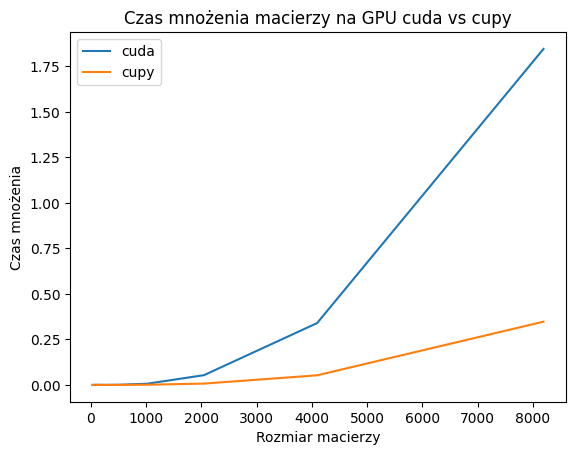

In [ ]:
import matplotlib.pyplot as plt
plt.clf()
x = Ns
y = times
x1 = Ns_cupy
y1 = times_cupy
plt.plot(x, y, label="cuda")
plt.plot(x1, y1, label="cupy")
plt.legend()
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas mnożenia")
plt.title("Czas mnożenia macierzy na GPU cuda vs cupy")
plt.show()

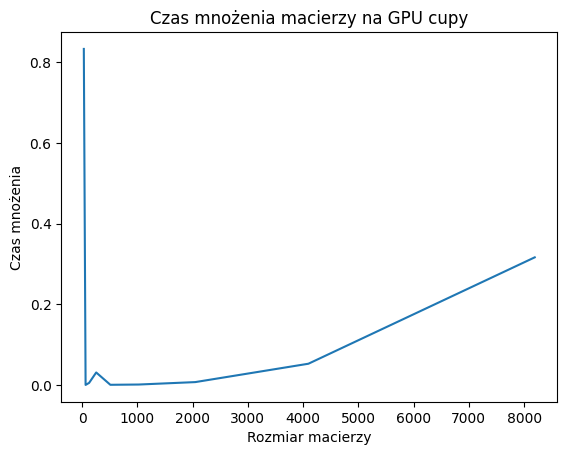

In [ ]:
plt.clf()

plt.plot(x, y)
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas mnożenia")
plt.title("Czas mnożenia macierzy na GPU cupy")
plt.show()